In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
import pandas as pd
from scipy.optimize import curve_fit
import pylab as pl
import numpy as np
from itertools import cycle

%matplotlib inline


def raleigh_range(beam_waist, wv_lambda):
    #change to mm
    wv_adjust = wv_lambda*(10**-6)
    wavelength_dependency = np.multiply(np.pi, np.square(beam_waist)) 
    return(np.divide(wavelength_dependency, wv_adjust))

def beam_waist(z, beam_waist_0, wv_lambda):
    #lambda is in nm, so it needs to be adjusted to mm 
    #call raleigh_range 
    curr_raleigh = raleigh_range(beam_waist_0, wv_lambda)
    z_ratio = np.divide(z,curr_raleigh)
    root_factor = np.sqrt(1 + np.square(z_ratio))
    return(np.multiply(beam_waist_0,root_factor))
    

def lens_waist_size(z, w0, wavelength, focal_length):
    #call raleigh range 
    curr_raleigh = raleigh_range(w0,wavelength)
    lens_factor = 1 - np.divide(z,focal_length)
    far_away_factor = np.divide(z,curr_raleigh)
    root = np.sqrt( np.square(lens_factor) + np.square(far_away_factor))
    return(np.multiply(w0, root))

def intensity(x,y,z,w_0,wv_lambda,i_0):
    wv_adjust = np.multiply(wv_lambda,10**-6) 
    
    beam_factor_amplitude = i_0*np.square(np.divide(w_0, beam_waist(z,w_0,wv_lambda)))
    
    x_component = -2*np.square(np.divide(x,beam_waist(z,w_0,wv_lambda)))
    y_component = -2*np.square(np.divide(y,beam_waist(z,w_0,wv_lambda)))
    
    ex = np.exp(x_component)
    ey = np.exp(y_component)
    
    total_i = beam_factor_amplitude*np.multiply(ex,ey)
    total_ix = np.multiply(beam_factor_amplitude,ex)
    total_iy = np.multiply(beam_factor_amplitude,ey)
    
    return(total_ix,total_iy, total_i)

def gaussian(x,const, mean,sigma):
    mean_factor = x - mean
    e_arg = np.exp(-np.divide( np.square(mean_factor), 2*np.square(sigma)))
    return(const*e_arg )

def fit_parameter_extractor(fit_func, data):
    #typically data is the list above, with the containers for each run
    #each container has the x and irradiance data (x,irradiance)
    #like this:
    # [data_1, data_2, ..., data_n]
    # [ (x_1,irr_1), (x_2,irr_2),...,(x_n, irr_n)]
    
    #containers
    sigma_arr = [] 
    mean_arr = []
    amp_arr = []
    err_const_arr = []
    err_mean_arr = []
    err_sigma_arr = []
    
    
    #iterate to the data
    for i in range(len(data)):
        #get the curve_fit method 
        popt, pcov = curve_fit(fit_func, data[i][0], data[i][1])
        #enter the values for (sigma, mean, amplitude)
        
        amp_arr.insert(i, popt[0])
        mean_arr.insert(i,popt[1])
        sigma_arr.insert(i,popt[2])
        
        #enter error values (1-std error)
        errors = np.sqrt(np.diag(pcov))
        err_const_arr.insert(i, errors[0])
        err_mean_arr.insert(i,errors[1])
        err_sigma_arr.insert(i,errors[2])
        
    return(amp_arr, mean_arr, sigma_arr, err_const_arr, err_mean_arr, err_sigma_arr)

def data_parser(file_path):
    curr_data = pd.read_csv(file_path, delimiter = '\t', encoding='utf-16', skiprows=11)
    #get parameters 
    curr_x = curr_data['  X Coordinate']
    curr_i = curr_data['    Irradiance']
    return(curr_x,curr_i)

def data_generator(empty_arr, path_list):
    for i in range(len(path_list)):
        empty_arr.insert(i, data_parser(path_list[i]))
        
def plot_generator(data_arr, num_rows, num_cols,
                   top_adjust_val, label_fontsize, 
                   title_fontsize, tick_params_fontsize
                  ,labelx_string, labely_string, title_string, 
                    label_arr, filename):
    cycol = cycle('bgrcmk')
    fig = plt.figure(figsize=(55,40))
    
    for pos in range(len(data_arr)):    
        axes = fig.add_subplot(num_rows, num_cols, pos+1)
        axes.plot(data_arr[pos][0], data_arr[pos][1], c = next(cycol), linestyle = '-.', label = str(label_arr[pos]))
        axes.tick_params(axis='both',labelsize=label_fontsize)
        axes.legend(fontsize =label_fontsize)
        axes.set_xlabel(labelx_string, fontsize=label_fontsize)
        axes.set_ylabel(labely_string, fontsize=label_fontsize)
        axes.tick_params(axis='both',labelsize=tick_params_fontsize)
        axes.legend(loc = 'upper right', fontsize=label_fontsize)
    
    fig.suptitle(title_string, fontsize=title_fontsize+5)
    fig.tight_layout()
    fig.subplots_adjust(top=top_adjust_val)
    fig.savefig(str(filename)+'jpg', dp1=1600)
   
    

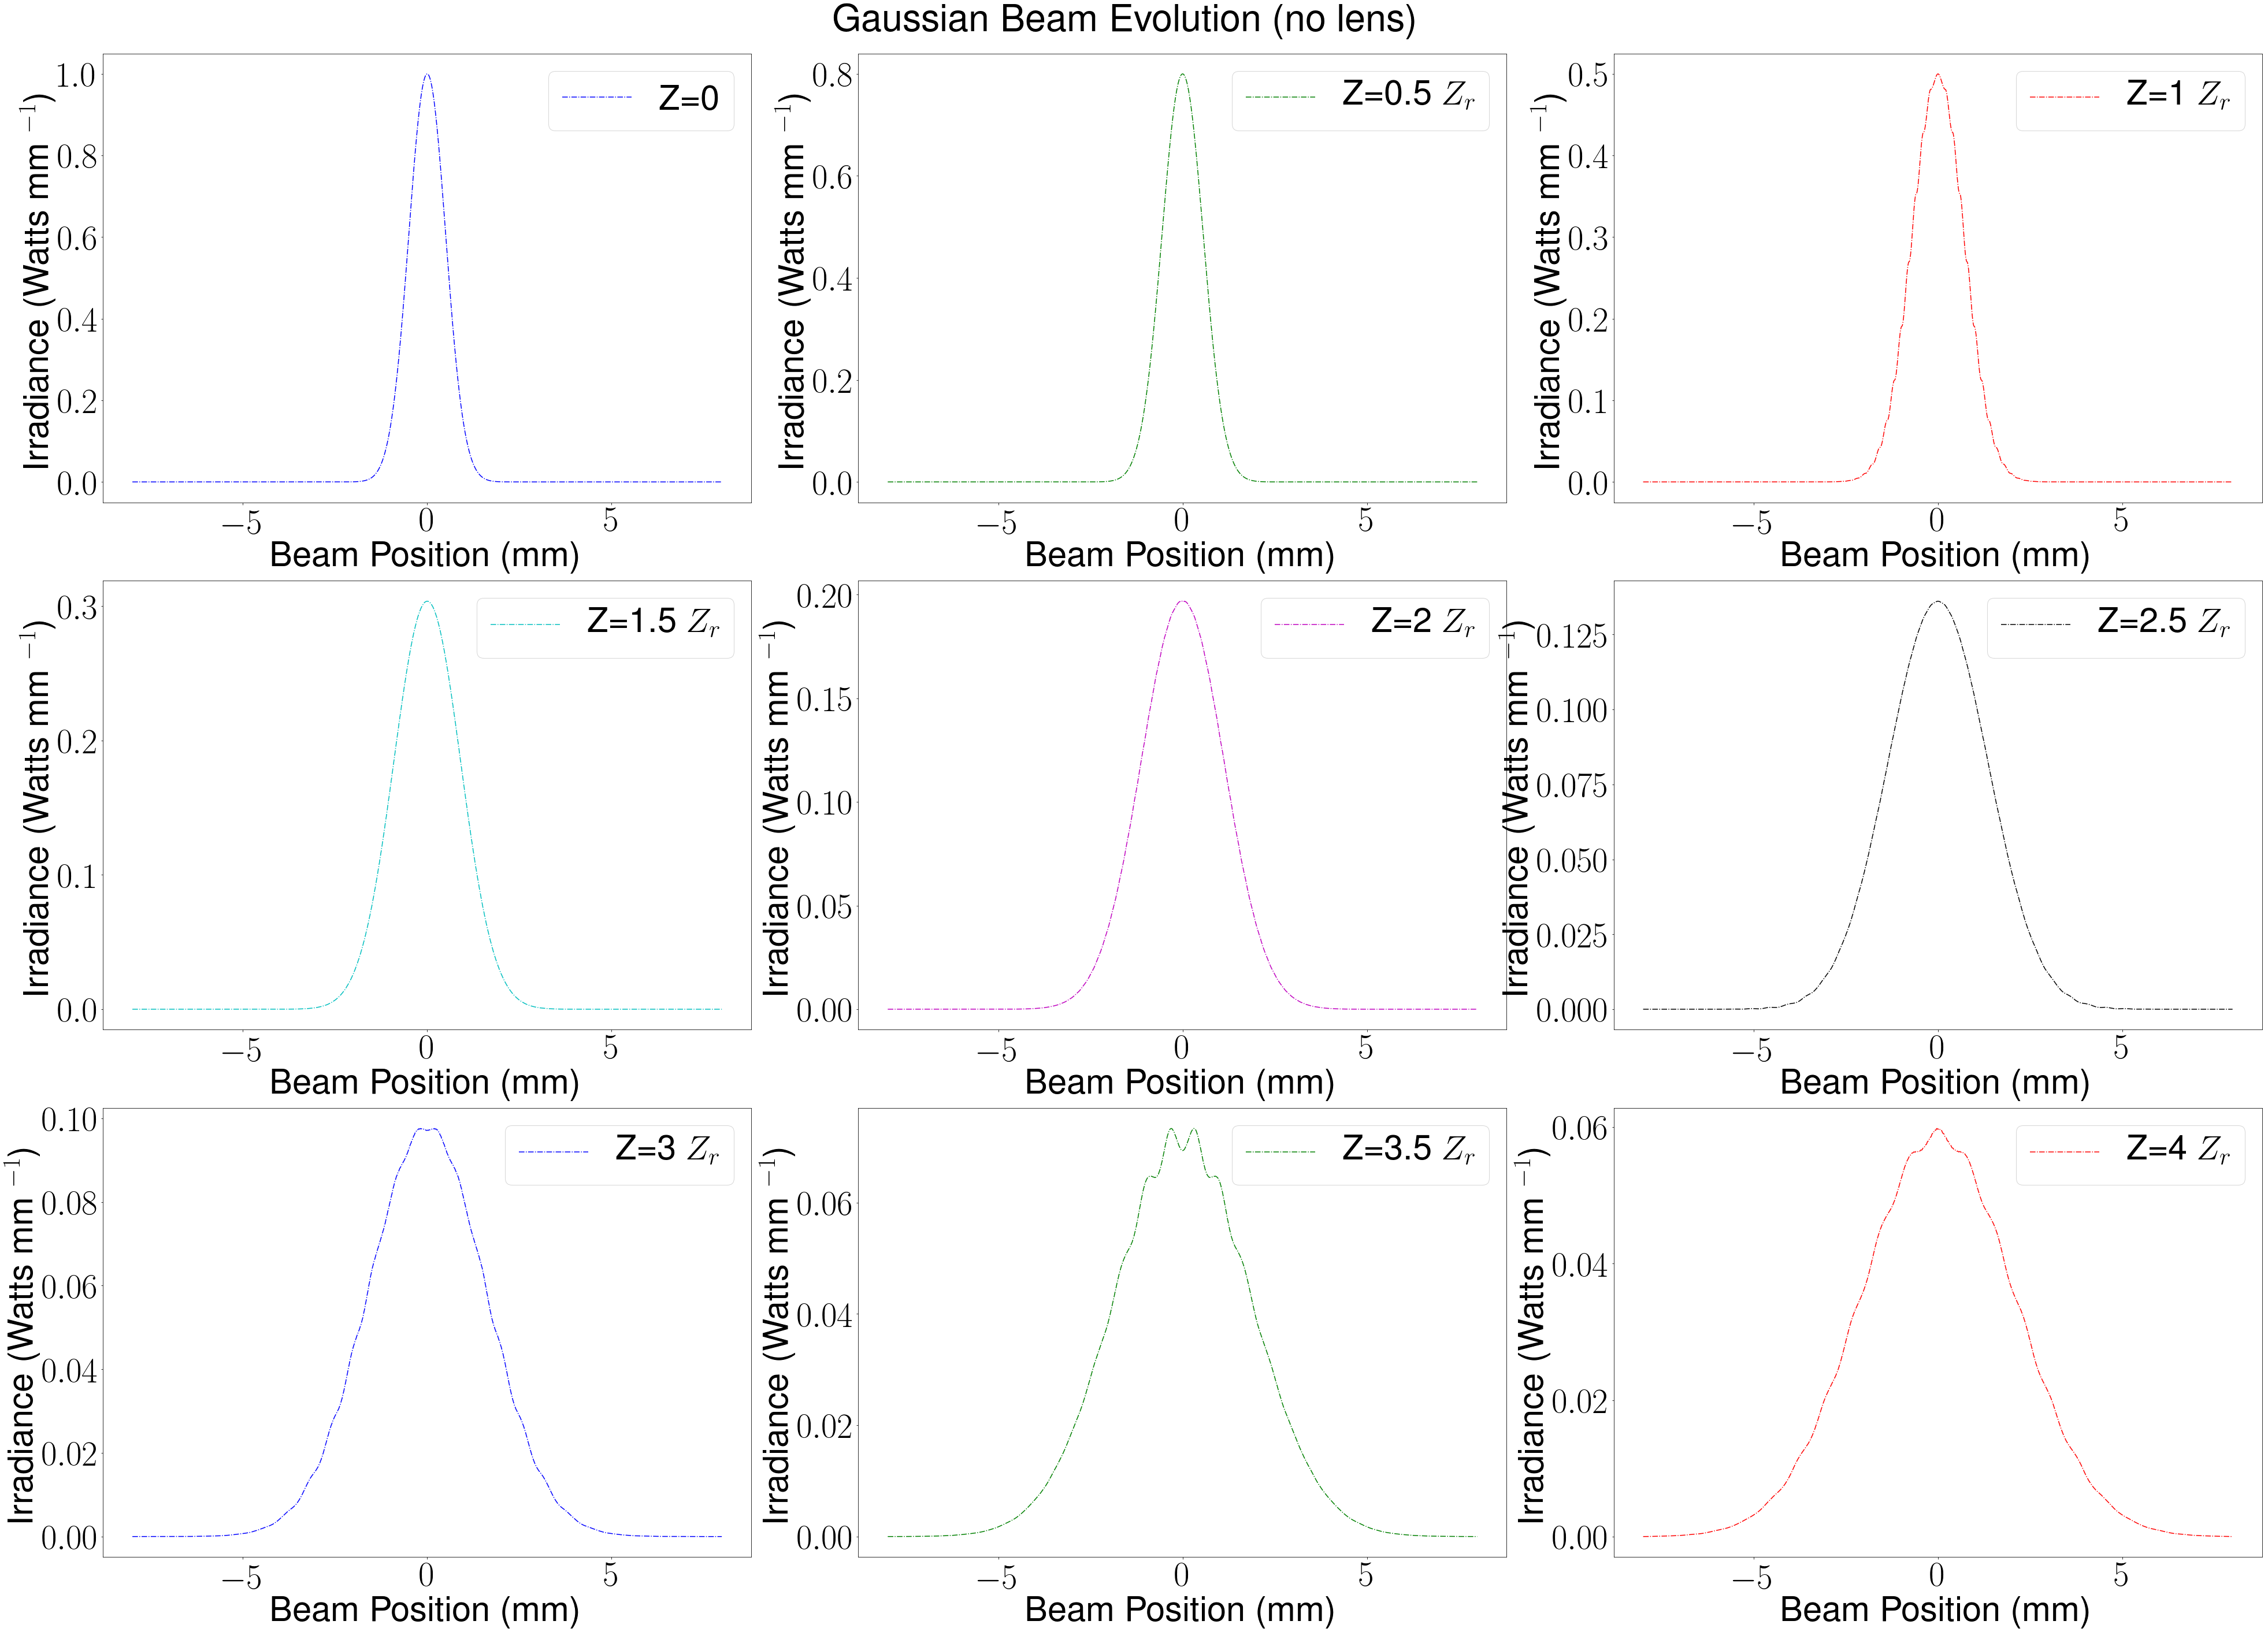

In [2]:
# data no lens 

datapath_no_lens = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/'

original_beam = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/data_z_0.csv'
half_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/data_z_0_5.csv'
_1_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/data_z_1.csv'
_1_5_raleigh ='/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/data_z_1_5.csv'
_2_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/data_z_2.csv'
_2_5_raleigh ='/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/data_z_2_5.csv'
_3_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/data_z_3.csv'
_3_5_raleigh ='/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/data_z_3_5.csv'
_4_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_no_lens/data_z_4.csv'

datapath_list_no_lens = [original_beam, half_raleigh, _1_raleigh, 
                     _1_5_raleigh, _2_raleigh, _2_5_raleigh,
                    _3_raleigh, _3_5_raleigh, _4_raleigh]

data_list_no_lens = []

labels = [ 'Z=0', 'Z=0.5 $Z_{r}$', 'Z=1 $Z_{r}$', 'Z=1.5 $Z_{r}$', 
          'Z=2 $Z_{r}$','Z=2.5 $Z_{r}$','Z=3 $Z_{r}$' ,'Z=3.5 $Z_{r}$' ,'Z=4 $Z_{r}$']
#extract the data 
data_generator(data_list_no_lens, datapath_list_no_lens)

#plot
'''
r'Irradiance (Watts mm $^{-1}$)'
r'$Z_{r}$','$W(z)$ (mm)'
def plot_generator(data_arr, num_rows, num_cols,
                   top_adjust_val, label_fontsize, 
                   title_fontsize, tick_params_fontsize
                  , labelx_string, labely_string,label_arr):
'''

plot_generator(data_list_no_lens,3,3, 
               0.95, 60, 
               60, 60,
               'Beam Position (mm)',r'Irradiance (Watts mm $^{-1}$)', 'Gaussian Beam Evolution (no lens)',
               labels, 'nolensslides')

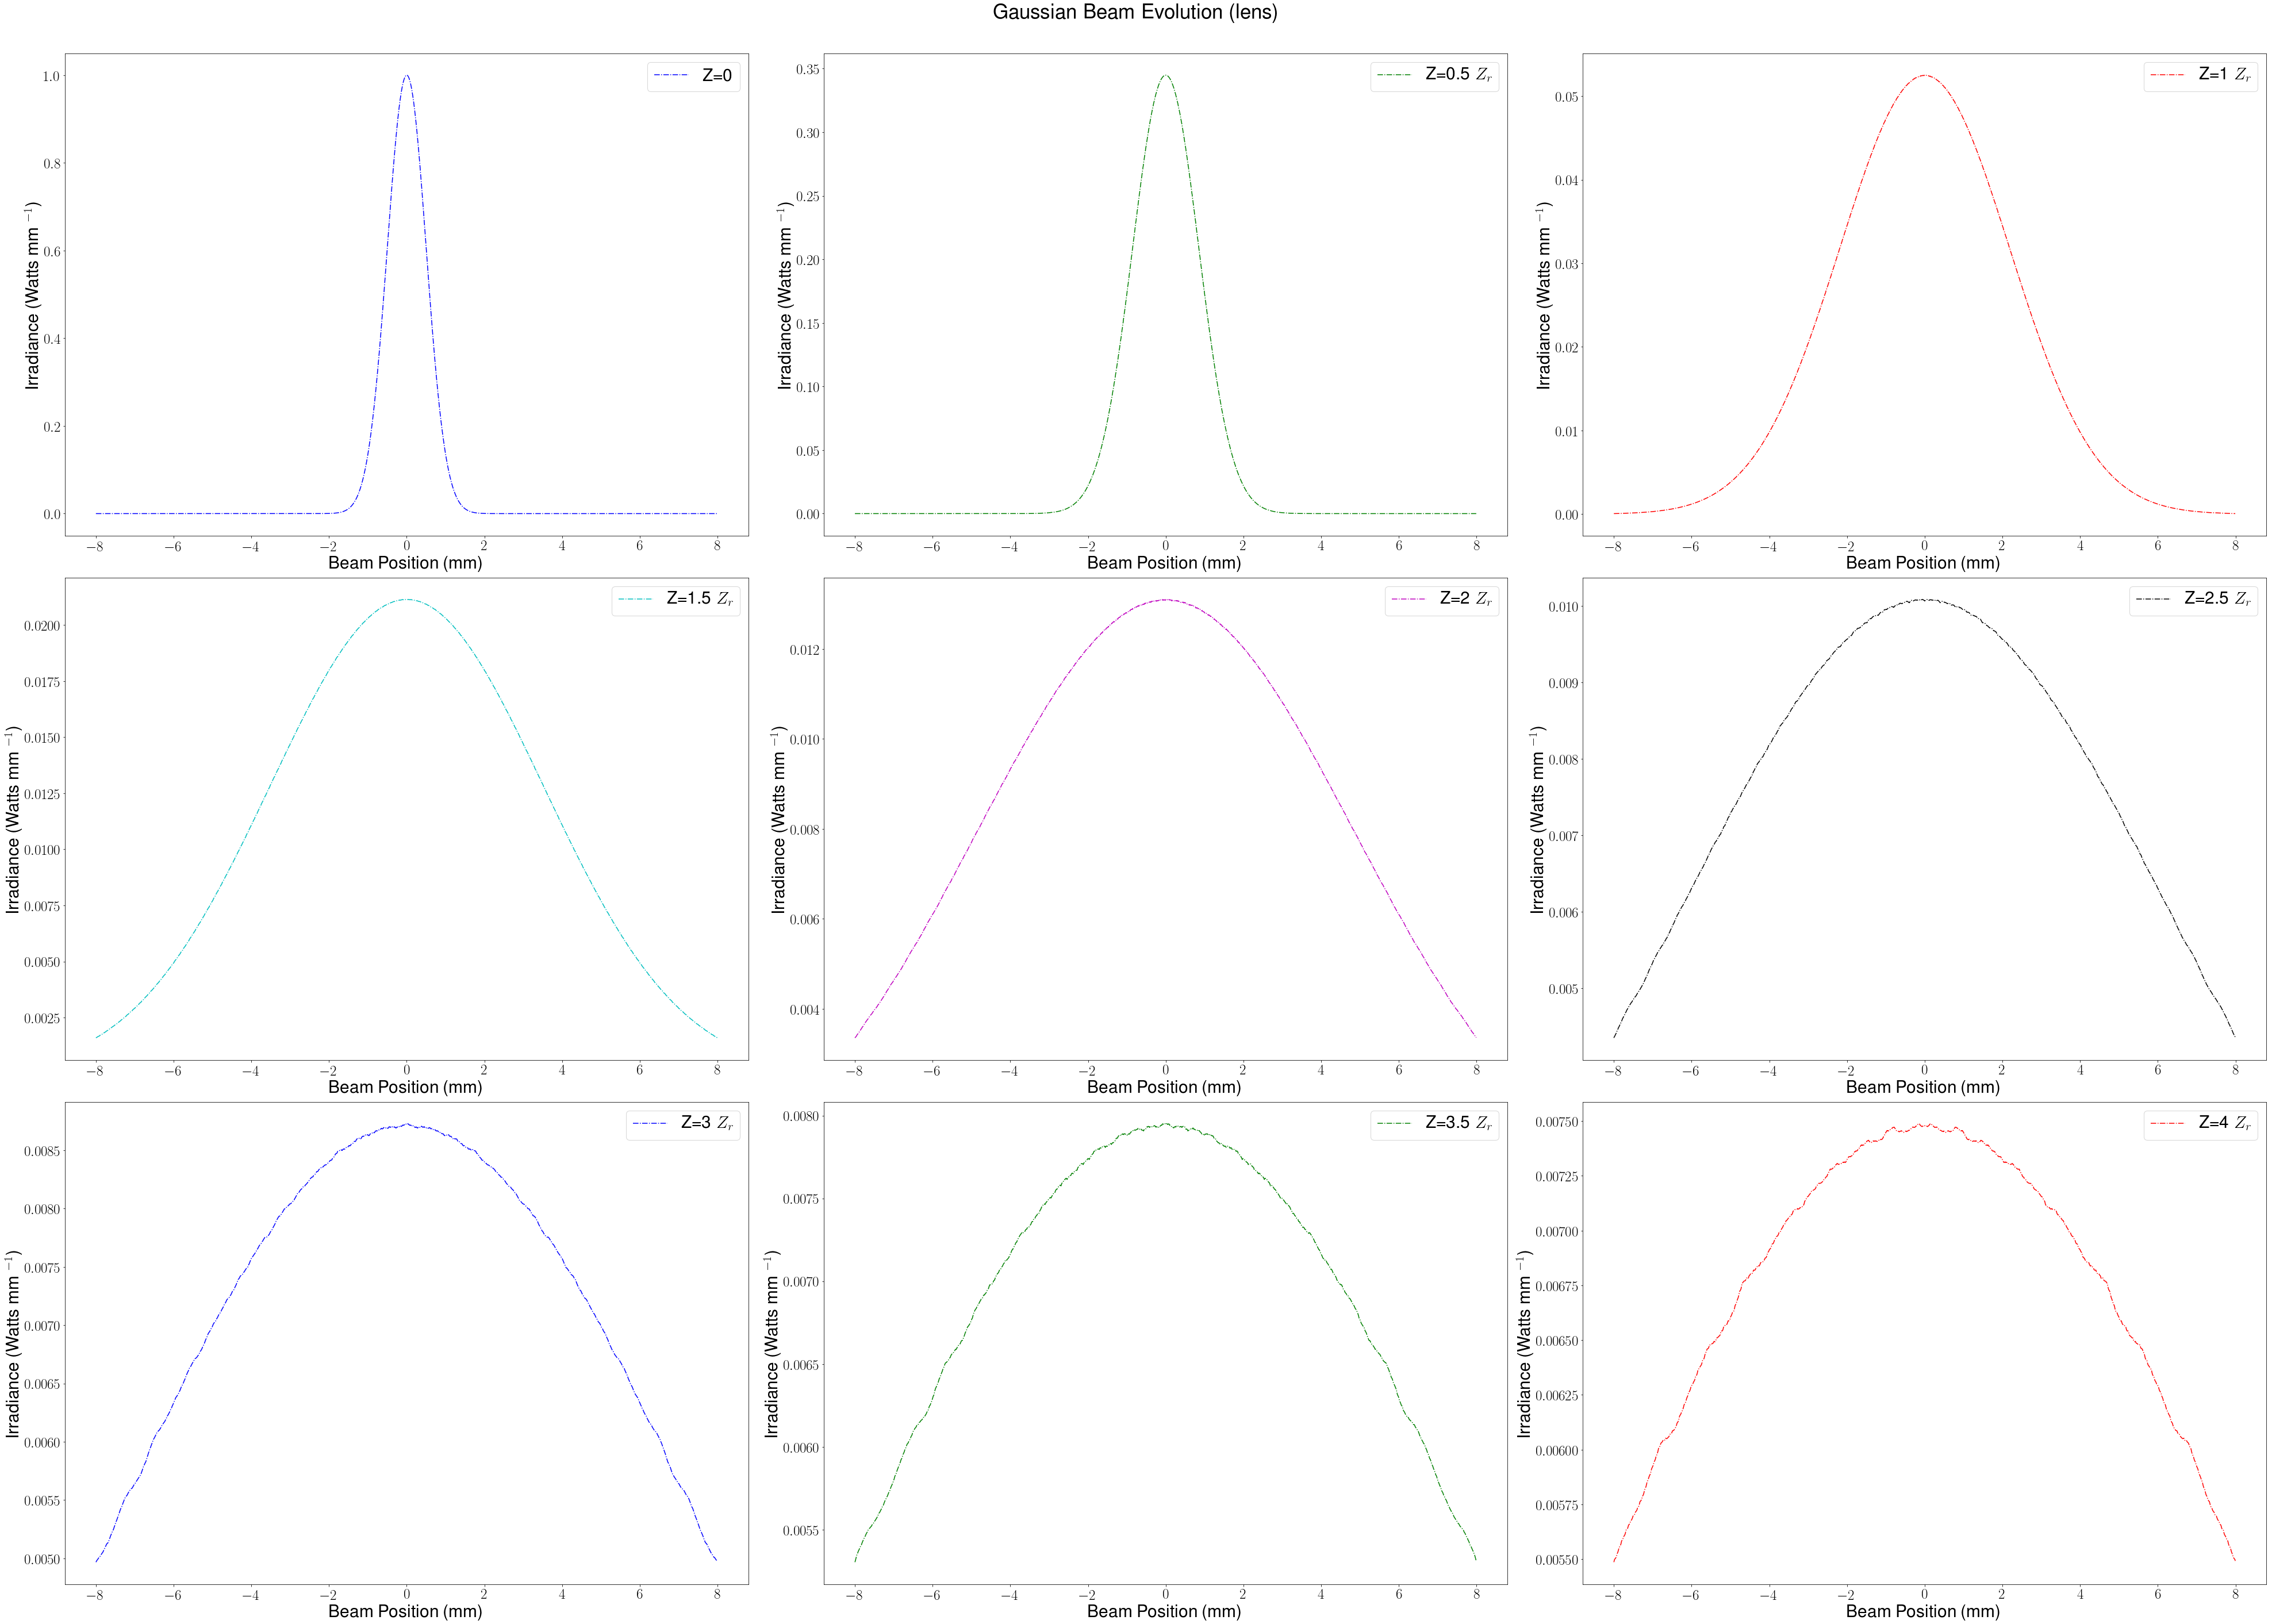

In [3]:
#lens data 

datapath_lens = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/'

lens_original_beam = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_0.csv'
lens_half_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_0_5.csv'
lens_1_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_1.csv'
lens_1_5_raleigh ='/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_1_5.csv'
lens_2_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_2.csv'
lens_2_5_raleigh ='/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_2_5.csv'
lens_3_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_3.csv'
lens_3_5_raleigh ='/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_3_5.csv'
lens_4_raleigh = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_4.csv'

lens_data_at_lens = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/data_z_lens.csv'

datapaths_lensdata = [lens_original_beam, lens_half_raleigh, lens_1_raleigh,
                      lens_1_5_raleigh, lens_2_raleigh, lens_2_5_raleigh,
                      lens_3_raleigh, lens_3_5_raleigh, lens_4_raleigh]

lens_data = []

data_generator(lens_data, datapaths_lensdata)

plot_generator(lens_data,3,3, 
               0.95, 30, 
               30, 25,
               'Beam Position (mm)',r'Irradiance (Watts mm $^{-1}$)', 'Gaussian Beam Evolution (lens)',
               labels, 'lensslides')

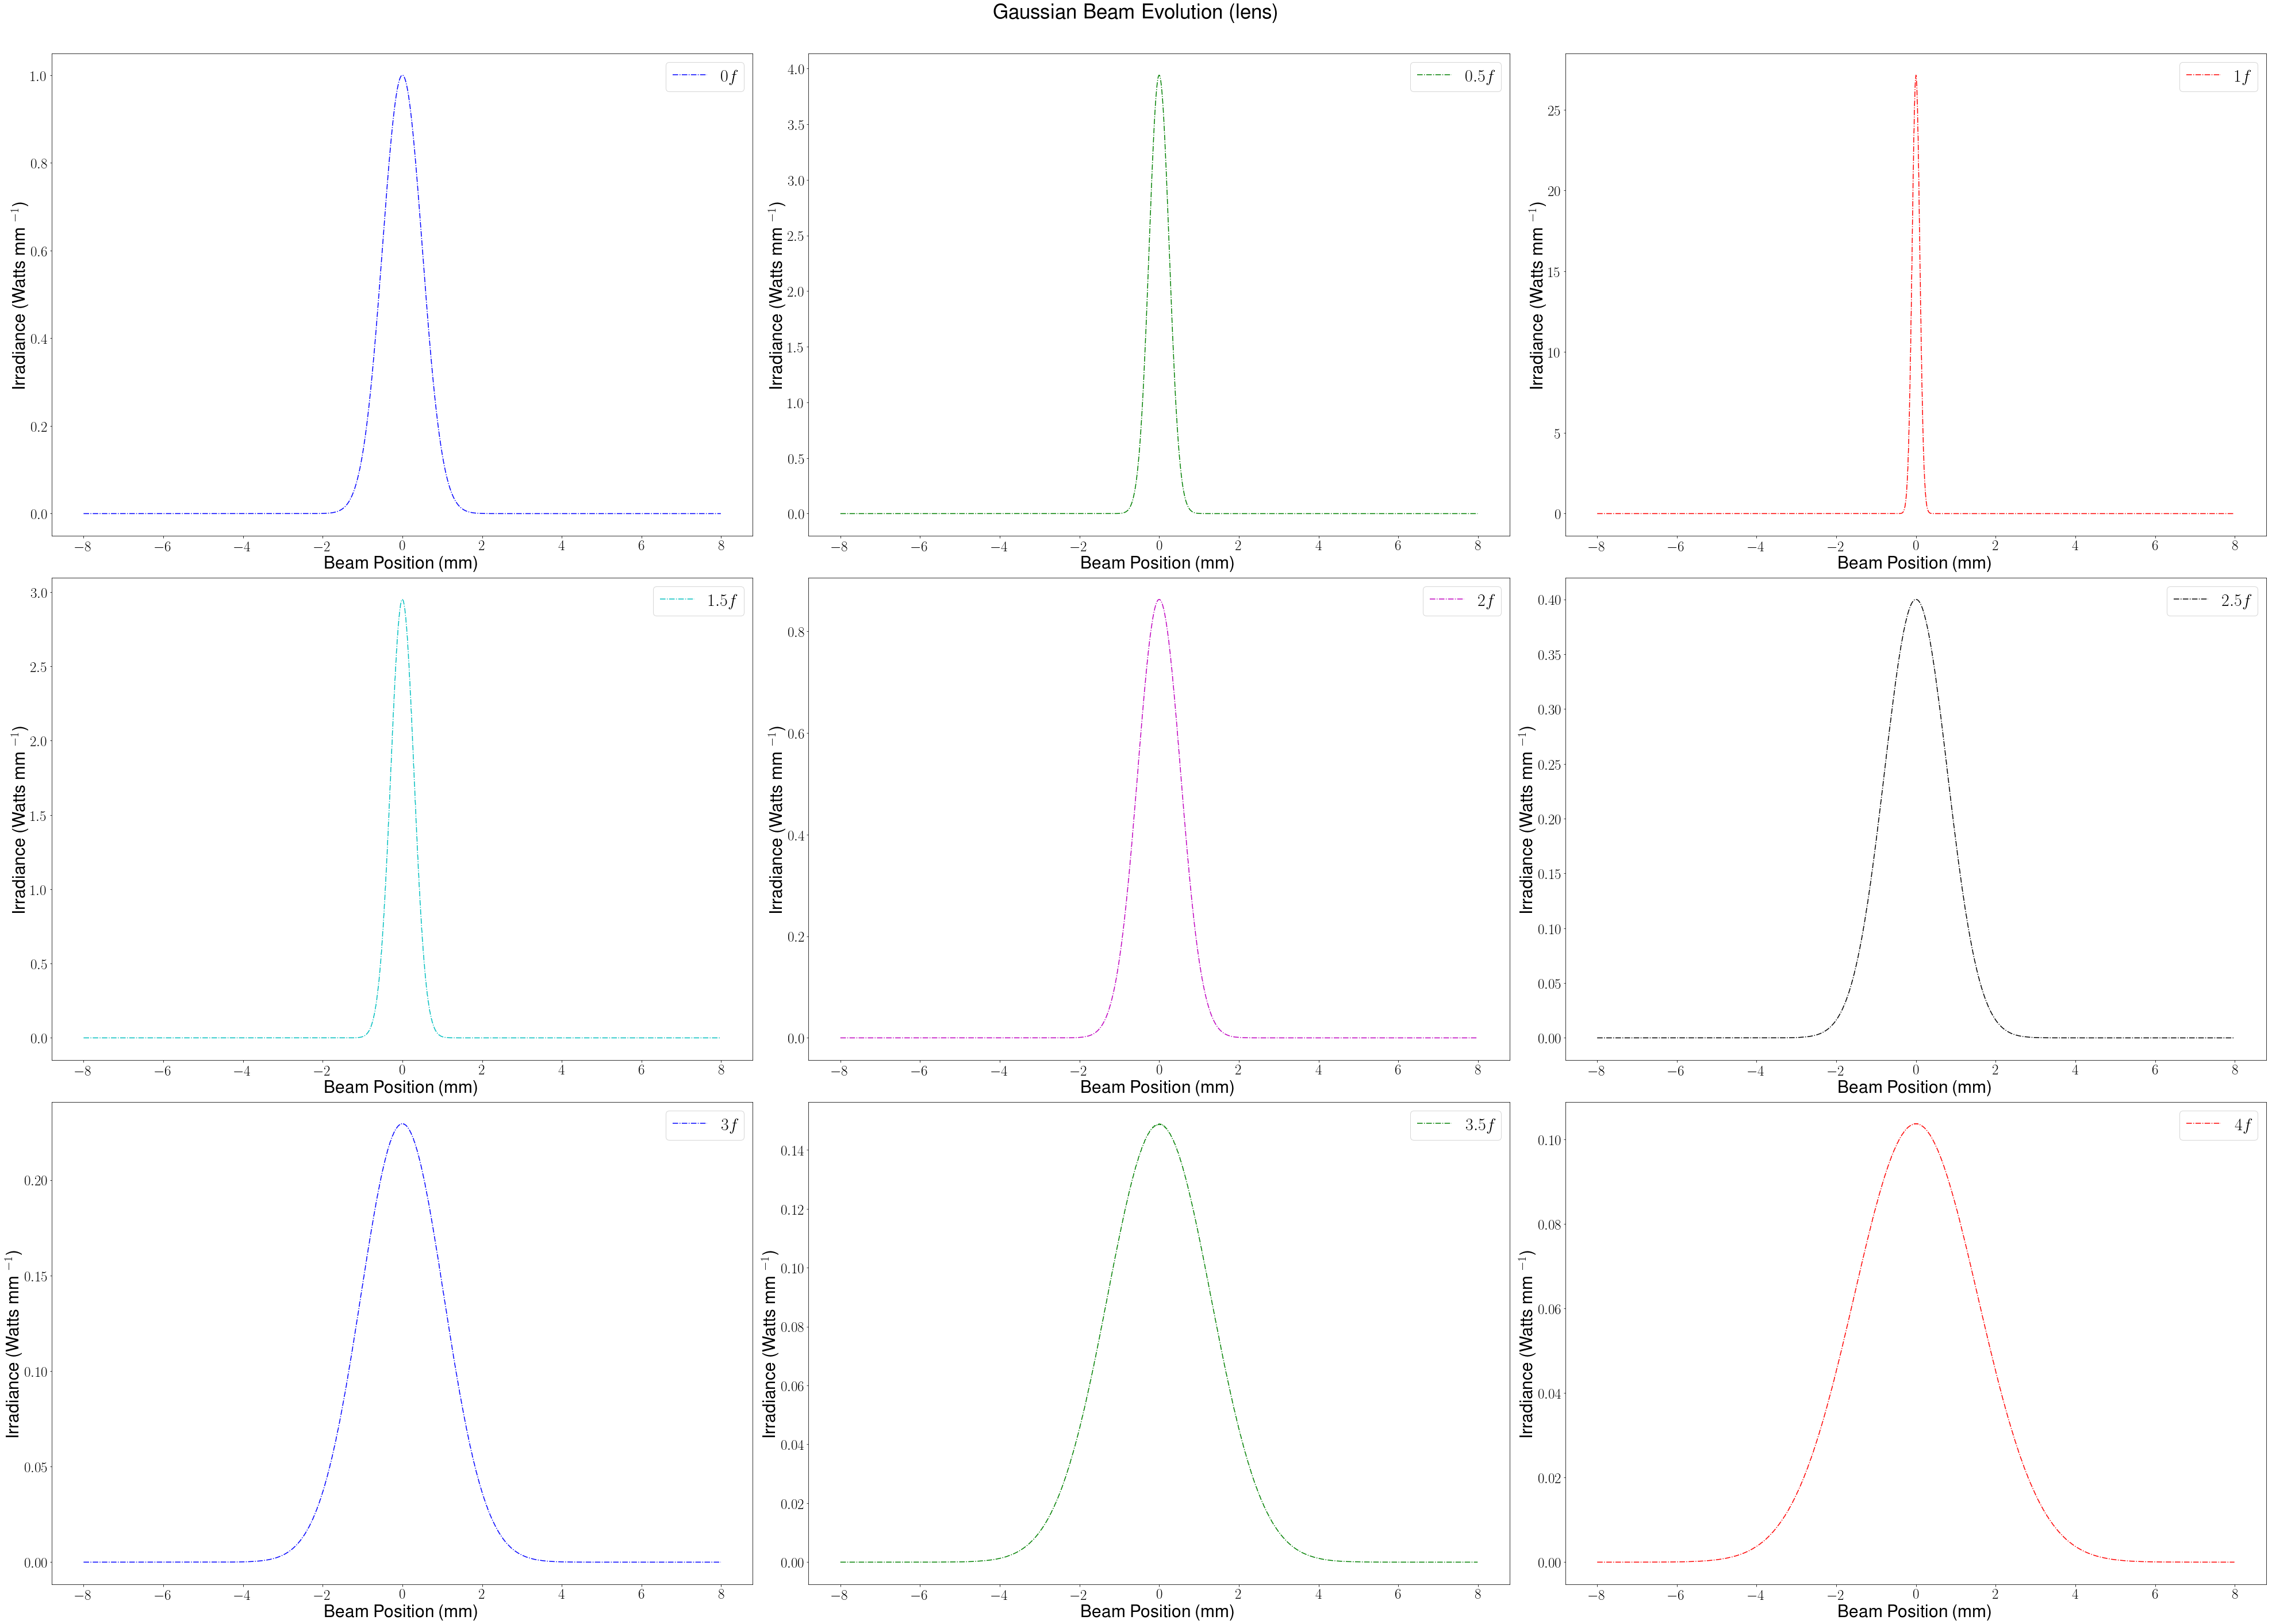

In [4]:
#data in focal range rather than raleigh range 



focal_lens_path = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/'

fl_original_beam = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_0.csv'

fl_half_f = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_0.5f.csv'   
fl_1_f = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_1f.csv'
fl_1_5_f ='/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_1.5f.csv'
fl_2_f = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_2f.csv'
fl_2_5_f ='/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_2.5f.csv'
fl_3_f = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_3.csv'
fl_3_5_f ='/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_3.5f.csv'
fl_4_f = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_4.csv'

focal_list = [fl_original_beam, fl_half_f, fl_1_f,
             fl_1_5_f, fl_2_f, fl_2_5_f,
             fl_3_f, fl_3_5_f, fl_4_f]

focal_data = []

labels = ['$0f$','$0.5f$', '$1f$', '$1.5f$', '$2f$', '$2.5f$', '$3f$','$3.5f$','$4f$']

data_generator(focal_data, focal_list)
plot_generator(focal_data,3,3, 
               0.95, 30, 
               30, 25,
               'Beam Position (mm)',r'Irradiance (Watts mm $^{-1}$)', 'Gaussian Beam Evolution (lens)',
               labels, 'flensslides')

fl_data_at_lens = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/waist_files/gauss_beam_lens/lensdatafocal/data_z_lens.csv'

5235.98775598
[0.50000002494875717, 0.25191586259061716, 0.096186319168862139, 0.2912071393924906, 0.53853790076749108, 0.79055637668156553, 1.0438675798504116, 1.2977251885246861, 1.5518416027194668]
minimum spot size for this beam:
0.0961863191689
9 9
1.0
0.504
0.192
0.582
1.077
1.581
2.088
2.595
3.104


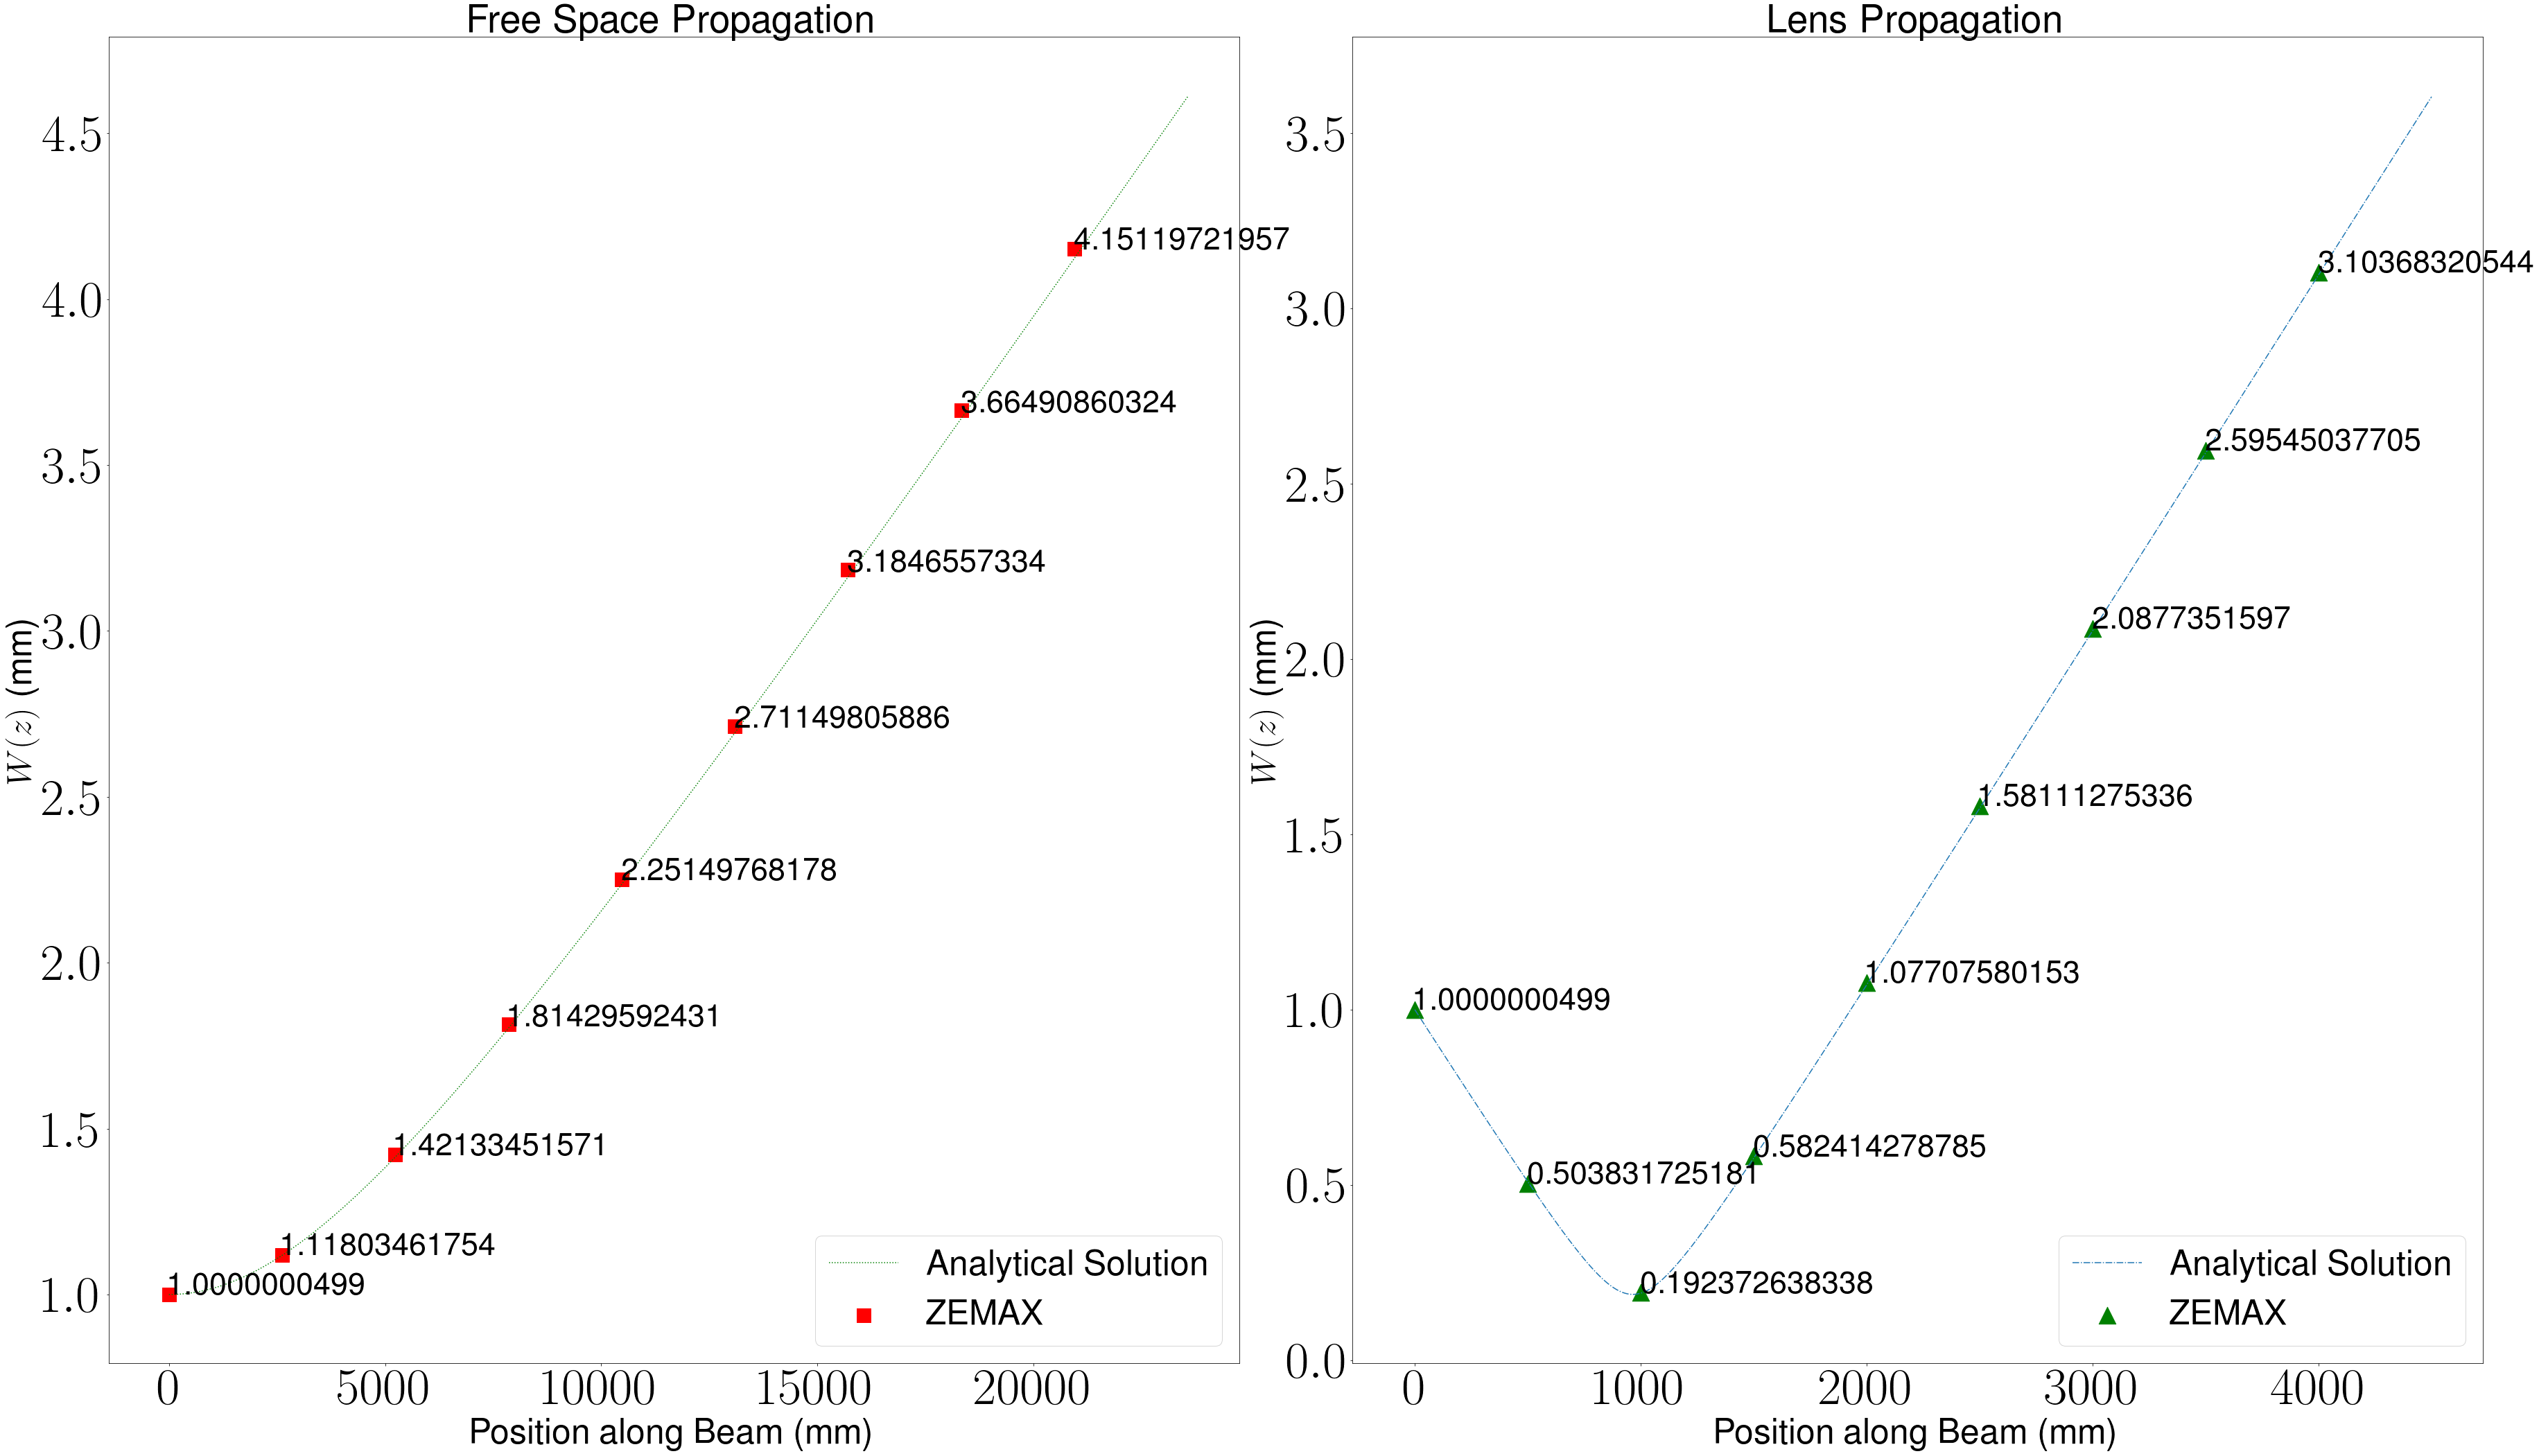

In [5]:
#analytical solution 
%matplotlib inline
raleigh_scale = raleigh_range(1,600)
print(raleigh_scale)
max_z_values = 4.5*raleigh_scale
step = np.divide(raleigh_scale,2)
focal_length = 1000

#analytical solution 
#curve_fit data 

curvedata = fit_parameter_extractor(gaussian, data_list_no_lens)
curvedata_lens = fit_parameter_extractor(gaussian, lens_data)

curvefocaldata_lens = fit_parameter_extractor(gaussian, focal_data)
print(curvefocaldata_lens[2])
print("minimum spot size for this beam:")
print(np.amin(curvefocaldata_lens[2]))
test_small_scale = np.multiply(2,curvedata[2])
test_lens_small_scale = np.multiply(2, curvedata_lens[2])
test_focal_lens_scale = np.multiply(2, curvefocaldata_lens[2])

range_small_scale = np.arange(0, max_z_values, step)
focal_range = np.arange(0, 4500, 500)

analytical_focal_range = np.arange(0,4500,0.01)
analytical_focal_waist = lens_waist_size(analytical_focal_range, 1, 600, 1000)
#plots
axis_along_beam = np.arange(0,max_z_values,0.01)
beam_val_estimation = beam_waist(axis_along_beam, 1,600)
rscale_axis = np.divide(axis_along_beam, raleigh_scale)

#actual fit
plt.figure(dpi=1200)
fig, axes = plt.subplots(1,2,figsize=(50,30))

#af = analytical_fit.add_subplot(22, figsize(20,20))
print(np.size(range_small_scale), np.size(test_focal_lens_scale))
axes[0].plot(axis_along_beam, beam_val_estimation, markevery=40000, linestyle = ':',label = 'Analytical Solution', color = 'green')
axes[0].scatter(range_small_scale, test_small_scale, marker = 's', color = 'red', label = 'ZEMAX', s=400)

a = np.around(test_small_scale, decimals=3)


for i, txt in enumerate(test_small_scale):
    axes[0].annotate(txt,(range_small_scale[i], np.round(test_small_scale[i], decimals=2)),  size=45 )

#
#af.scatter(focal_range, test_focal_lens_scale, marker = '^', color = 'orange', label = r'Lens ($f=1000$ mm)', s=150)



axes[1].plot(analytical_focal_range, analytical_focal_waist, label = 'Analytical Solution', linestyle = '-.')
axes[1].scatter(focal_range, test_focal_lens_scale, marker = '^', color = 'green', label = 'ZEMAX', s=600)
#af.errorbar(range_small_scale, test_small_scale, xerr=curvedata[5], color = 'indigo', fmt = 'o')

a = np.around(test_focal_lens_scale, decimals=8)


for i, txt in enumerate(test_focal_lens_scale):
    a1 = np.round(a[i],3)
    print(a1)
    axes[1].annotate(txt,(focal_range[i],a1) , size=45 )

axes[0].set_xlabel('Position along Beam (mm)', fontsize=50)
axes[0].set_ylabel('$W(z)$ (mm)', fontsize=50)
axes[0].legend(loc = 'lower right', fontsize=50)
axes[0].tick_params(axis='both', labelsize=75)

axes[1].set_xlabel('Position along Beam (mm)', fontsize=50)
axes[1].set_ylabel('$W(z)$ (mm)', fontsize=50)
axes[1].legend(loc = 'lower right', fontsize=50)
axes[1].tick_params(axis='both', labelsize=75)



axes[0].set_title("Free Space Propagation", fontsize=55)
axes[1].set_title("Lens Propagation", fontsize=55)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.savefig('comparisonmethods.jpg', dp1=18000)


In [6]:
print( 1/ (1/1000) + (1000/5000))

1000.2
